# Accessing synapse and spine info of the MICrONS data

The MICrONS initiative provided a dense reconstruction of around a cubic milimeter of mouse brain tissue.

At OBI, we have converted that data into the SONATA format that is often used to represent biophysically-detailed computational models of neuronal circuitry. We believe that this is a useful resource for the community for the following reasons:
 1. It allows direct comparison of models to the data, as both are in the same format. In the future it may even be possible to simulate the MICrONS circuitry as one simulates the computational models.
 2. There are many useful code libraries for analyzing SONATA-formatted circuits.
 3. It is reduced representation of the data. While this discards a lot of information, what remains is still very useful for many purposes. And the reduced data can be more easily handled and analyzed faster.
 4. During the conversion to SONATA we added derived data. Specifically, high-quality morphology skeletons with extracted spines.


Here, we want to expand on point (4) above. We demonstrate some example of how to access spine- and synapse-related data.

### Summary of the analysis

This is less of an analysis and more of a demonstration of how to access spine- and synapse-related data of the MICrONS data, represented in the SONATA format. It serves to teach you the basics of structural analyses of SONATA circuits.

However, as examples, we calculate the fractions and number of shaft vs. spine synapses of 100 neurons, and the propertions of pre-synaptic neuron types.

## Importing code libraries and loading the data

We import a number of standard packages, as well as _bluepysnap_ and _neurom_. These two packages provide (as we will see) useful functionality for accessing the data in the SONATA format.

In [ ]:
import numpy
import pandas
import tqdm

import bluepysnap as snap
from matplotlib import pyplot as plt

circ_fn = "../../../../shared_data/MICrONS_SONATA/circuit_config.json"
circ = snap.Circuit(circ_fn)

## Node populations

The neurons in a SONATA circuit can be split into different _node populations_.
To represent the MICrONS data, we have decided to split it as follows:
  - An "intrinsic" population that contains the neurons with somata inside the reconstructed volume. Except for a small fraction (~15%) of neurons in the very periphery of the volume. As these peripheral neurons are likely to be severely affected by an edge effect in terms of their connectivity and hence should be excluded from analyses.
  - A "virtual" population representing the ~15% of neurons in the periphery that were excluded.
  - An "extrinsic" population representing neurons outside the reconstructed volume innervating neurons inside it. As these neurons are outside the volume, we know nothing about them, except that they must exist. 

We displaying the names of the node populations.

In [2]:
display(list(circ.nodes))

['em_extrinsic', 'microns_intrinsic', 'virtual_microns_intrinsic']

The intrinsic node population ("microns_inotrinsic") is the most interesting one. Each neuron in the population is associated with a number of "node properties" that represent, e.g., its location, neuron type, etc.

We display the available node, i.e., neuron properties.

In [3]:
node_pop = circ.nodes["microns_intrinsic"]

display(node_pop.property_names)

{'layer',
 'morphology',
 'mtype',
 'orientation_w',
 'orientation_x',
 'orientation_y',
 'orientation_z',
 'pt_root_id',
 'source__pt_supervoxel_id',
 'source__target_id',
 'source__volume',
 'spine_info',
 'synapse_class',
 'x',
 'y',
 'z'}

For the intrinsic population, we load a number of available property values and display them.

In [4]:
node_properties_to_load = ["layer", "morphology", "mtype", "spine_info", "synapse_class", "x", "y", "z"]
nrn_props = node_pop.get(properties=node_properties_to_load)

display(nrn_props.head())

,layer,morphology,mtype,spine_info,synapse_class,x,y,z
node_ids,,,,,,,,
0,3,_NONE,L3a,_NONE,EXC,1161.280,520.576,711.88
1,3,_NONE,L3a,_NONE,EXC,1162.112,514.240,696.60
2,3,_NONE,L3b,_NONE,EXC,1177.280,535.296,713.52
3,3,_NONE,L3a,_NONE,EXC,1159.552,510.848,718.00
4,4,_NONE,L4b,_NONE,EXC,1167.232,568.448,716.40


### Morphologies available for a fraction of neurons

As we saw, above the entry for "morphology" is "_NONE" for most neurons. That indicates that we have not yet skeletonized the morphology for that neuron. At the moment, we have made available morphologies for only 85 neurons, but that number is steadily growing.

Here, we create a DataFrame of neurons with available morphologies. Its index "node_ids" provides the identifiers of those neurons for future analyses.

In [5]:
nrn_props = nrn_props.loc[nrn_props["morphology"] != "_NONE"]
display(nrn_props.head())

,layer,morphology,mtype,spine_info,synapse_class,x,y,z
node_ids,,,,,,,,
22951,4,864691136664127454,L4a,spines_864691136664127454,EXC,649.792,637.760,922.80
22984,3,864691135502873666,L3b,spines_864691135502873666,EXC,647.680,575.616,872.96
24054,3,864691134949221372,L3b,spines_864691134949221372,EXC,644.672,553.216,787.92
24392,3,864691134948788476,L3a,spines_864691134948788476,EXC,631.872,565.824,865.92
24471,3,864691135953985800,L3b,spines_864691135953985800,EXC,599.360,543.552,950.12


Just as neurons, the synapses are also split into separate _edge populations_ that represent synapses between different pairs of node populations.

Display edge populations

In [6]:
edge_pop_names = list(circ.edges)
display(edge_pop_names)

['em_extrinsic__microns_intrinsic__chemical',
 'microns_intrinsic__microns_intrinsic__chemical',
 'virtual_microns_intrinsic__microns_intrinsic__chemical']

Display available edge (i.e., synapse) properties

In [7]:
edge_properties_to_load = list(circ.edges[edge_pop_names[1]].property_names)

display(edge_properties_to_load)

['afferent_synapse_y',
 'afferent_surface_x',
 'afferent_surface_y',
 'afferent_segment_id',
 'afferent_section_id',
 '@target_node',
 'afferent_segment_offset',
 '@source_node',
 'spine_id',
 'afferent_section_offset',
 'afferent_surface_z',
 'afferent_synapse_x',
 'source__id',
 'source__size',
 'afferent_synapse_z']

We pick an exemplary neuron with available morphology.

Then we load its afferent synapse properties from all available edge populations. For that purpose, we define a helper function that iterates over edge populations.

In [8]:
nrn_id = nrn_props.index[10]

def synapses_from_all_edge_populations(nrn_id):
    syns = []; keys=[]
    for edge_pop in edge_pop_names:
        pop_syns = circ.edges[edge_pop].afferent_edges(nrn_id, properties=edge_properties_to_load)
        if len(pop_syns) > 0:
            syns.append(pop_syns)
            keys.append(edge_pop)
    syns = pandas.concat(syns, axis=0, keys=keys, names=["edge_population"])
    return syns

synapses = synapses_from_all_edge_populations(nrn_id)
display(synapses)

afferent_synapse_y  \
edge_population                                                                 
em_extrinsic__microns_intrinsic__chemical          29227              368.624   
                                                   29228              496.352   
                                                   29229              469.212   
                                                   29230              396.228   
                                                   29231              437.660   
...                                                                       ...   
virtual_microns_intrinsic__microns_intrinsic__c... 646386             357.340   
                                                   646387             457.032   
                                                   646388             454.104   
                                                   646389             492.760   
                                                   646390             513.776   

                                                           afferent_surface_x  \
edge_population                                                                 
em_extrinsic__microns_intrinsic__chemical          29227           584.992981   
                                                   29228           677.476318   
                                                   29229           605.235168   
                                                   29230           678.503052   
                                                   29231           668.088623   
...                                                                       ...   
virtual_microns_intrinsic__microns_intrinsic__c... 646386          551.329346   
                                                   646387          680.043213   
                                                   646388           -1.000000   
                                                   646389          677.402954   
                                                   646390          626.504150   

                                                           afferent_surface_y  \
edge_population                                                                 
em_extrinsic__microns_intrinsic__chemical          29227           370.861511   
                                                   29228           495.767212   
                                                   29229           469.069824   
                                                   29230           396.458740   
                                                   29231           439.952026   
...                                                                       ...   
virtual_microns_intrinsic__microns_intrinsic__c... 646386          357.366119   
                                                   646387          457.994812   
                                                   646388           -1.000000   
                                                   646389          492.686768   
                                                   646390          513.149902   

                                                           afferent_segment_id  \
edge_population                                                                  
em_extrinsic__microns_intrinsic__chemical          29227                   192   
                                                   29228                   848   
                                                   29229                   343   
                                                   29230                   202   
                                                   29231                   178   
...                                                                        ...   
virtual_microns_intrinsic__microns_intrinsic__c... 646386                   61   
                                                   646387                   18   
                                                   646388                   4

### Extrinsic vs. intrinsic innervation

With the loaded data, we can already calculate the number of extrinsic vs. intrinsic synapses. A theoretically important quantity.

Note that at the moment we make "extrinsic" synapses only available for neurons with available morphology. In the future we will provide extrinsic info also for other neurons.

In [9]:
synapses.reset_index()["edge_population"].value_counts()

edge_population
em_extrinsic__microns_intrinsic__chemical                 5159
microns_intrinsic__microns_intrinsic__chemical             402
virtual_microns_intrinsic__microns_intrinsic__chemical       7
Name: count, dtype: int64

We saw that most synapses are, indeed extrinsic!

We now write a quick widget that allows to perform that analysis for all neurons. 
Use the slider to iterate over neurons 

In [10]:
from ipywidgets import widgets

wgt_nrn_id = widgets.IntSlider(min=0, max=len(nrn_props)-1, step=1, value=0, description="Neuron index")

def display_fun(idx):
    synapses = synapses_from_all_edge_populations(nrn_props.index[idx])
    per_population_count = synapses.reset_index()["edge_population"].value_counts().sort_index()

    _ = plt.pie(per_population_count, labels=per_population_count.index)

i = widgets.interactive(display_fun, idx=wgt_nrn_id)
display(i)

interactive(children=(IntSlider(value=0, description='Neuron index', max=876), Output()), _dom_classes=('widge…

### Small tangent: Presynaptic neuron types

This is unrelated to spines. But we can also look up the neuron types of the presynaptic neurons.

To that end, we simply use the "get" function of the corresponding pre-synaptic node population for the "mtypes" of the innervating neurons.

Note that this is NOT possible for extrinsic synapses. Because the sources of extrinsic synapse are by definition outside the reconstructed volume, so we have no information about those neurons. 

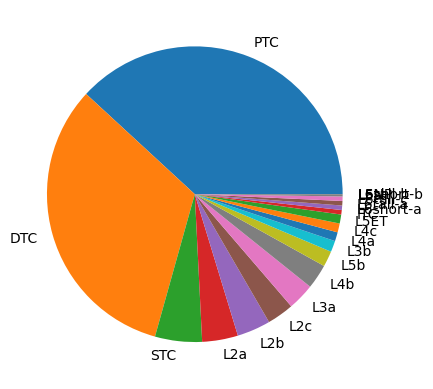

In [11]:
non_extrinsics = synapses.drop(index=["em_extrinsic__microns_intrinsic__chemical"], errors="ignore")

def lookup_presynaptic_property(df_in, property_names):
    edge_pop = df_in.index[0][0]
    source_name = circ.edges[edge_pop].source.name
    lo = circ.nodes[source_name].get(df_in["@source_node"], properties=property_names)
    return lo.reindex(df_in["@source_node"])

pre_mtypes = non_extrinsics.groupby("edge_population").apply(lookup_presynaptic_property, "mtype")
pre_mtype_counts = pre_mtypes.value_counts()

_ = plt.pie(pre_mtype_counts, labels=pre_mtype_counts.index)

The neuron type classification used above uses "PTC" to denote an inhibitory "proximally targeting cell", i.e., a Basket Cell. And "DTC" is an inhibitory "distally targeting cell", i.e. SST-positive neurons.

Again, we can also do this with a little interactive widget.

In [12]:
from ipywidgets import widgets

wgt_nrn_id = widgets.IntSlider(min=0, max=node_pop.count(), step=1, value=0, description="Neuron index")


def display_fun(nrn_id):
    synapses = synapses_from_all_edge_populations(nrn_id)
    non_extrinsics = synapses.drop(index=["em_extrinsic__microns_intrinsic__chemical"], errors="ignore")
    pre_mtypes = non_extrinsics.groupby("edge_population").apply(lookup_presynaptic_property, ["mtype"])    
    pre_mtype_counts = pre_mtypes["mtype"].value_counts().sort_index()

    ax = plt.figure().gca()
    _ = ax.pie(pre_mtype_counts, labels=pre_mtype_counts.index)

i = widgets.interactive(display_fun, nrn_id=wgt_nrn_id)
display(i)

interactive(children=(IntSlider(value=0, description='Neuron index', max=50948), Output()), _dom_classes=('wid…

## Finally: Accessing spine data

We write a small helper function to access and load the extracted spine data for a neuron.

We represent spines at three levels of detail:
  1. Surface meshes of spines
  2. Morphology-skeletons of spines, i.e., as line-segments with diameters
  3. As a simple line segment from the root of the spine to its tip.

At the moment and in this example, we only make (3) available. In the future, also (2) and (1) will be released.

In [ ]:
import os, json

def read_spine_info(node_pop, nrn_id):
    spines_root = os.path.split(node_pop.config["alternate_morphologies"]["h5v1"])[0]
    spines_fn = os.path.join(spines_root, "_SPINES.h5")
    return pandas.read_hdf(spines_fn, nrn_props.loc[nrn_id, "spine_info"])

spine_info = read_spine_info(node_pop, nrn_id)
display(spine_info.head())

,dendritic_sample_position,direction_vector,index,orientation_vector,surface_sample_position,synaptic_radius
0,"[501.970703125, 408.04718017578125, 971.234802...","[-0.7071068286895752, -0.7071068286895752, 0.0]",0,"[-0.18460112810134888, -0.6523560881614685, 0....","[501.8973388671875, 407.97381591796875, 971.23...",2.097537
1,"[501.970703125, 408.04718017578125, 971.234802...","[-0.5773502588272095, 0.5773502588272095, -0.5...",1,"[-0.5774303674697876, 0.5773102045059204, -0.5...","[501.8973388671875, 408.12054443359375, 971.16...",0.262255
2,"[508.2047119140625, 458.9482727050781, 934.855...","[-0.7074009776115417, 0.0, -0.7068124413490295]",2,"[-0.19919250905513763, -0.0577564463019371, -0...","[508.13134765625, 458.9482727050781, 934.78253...",0.824192
3,"[508.4247131347656, 451.61383056640625, 936.68...","[0.7072538733482361, 0.7069596648216248, 0.0]",3,"[0.7249574065208435, 0.28600457310676575, 0.41...","[508.4980773925781, 451.6871643066406, 936.689...",1.066523
4,"[509.0848083496094, 443.7659606933594, 938.889...","[-0.3333641290664673, -0.666589617729187, -0.6...",4,"[-0.3849268853664398, -0.6205800175666809, -0....","[509.0114440917969, 443.6192626953125, 938.743...",0.540249


A quick explanation of the above:

Each row of the DataFrame represents a spine on the morphology of the neuron. The columns are as follows:
  - dendritic_sample_position: x,y,z coordinates of the location of the spine on the morphology skeleton, i.e., on the center line of the dendrite
  - surface_sample_position: x,y,z coordinates of the location of the root of the spine on the dendrite surface
  - direction_vector: The direction from surface_sample_position to dendritic_sample_position
  - orientation_vector: A vector pointing from surface_sample_position towards the tip of the spine
  - synaptic radius: The distance of the tip of the spine from surface_sample_position

## Fractions of shaft- and spine-synapses

We use the above to calculate for all neurons their numbers of spine- and shaft-synapses. 

In [ ]:
fn_df_with_spine_info = "~/shared_data/MICrONS_SONATA/nrn_with_spine_info.h5"

if os.path.isfile(fn_df_with_spine_info):
    nrn_props = pandas.read_hdf(fn_df_with_spine_info, "nrn")
else:
    for nrn_id in tqdm.tqdm(nrn_props.index):
        spines = read_spine_info(node_pop, nrn_id)
        nrn_props.loc[nrn_id, "spine_count"] = len(spines)  # Each row of the DataFrame is a spine. Hence len is the spine count.
        
        syns = synapses_from_all_edge_populations(nrn_id)
        count_on_spines = (syns["spine_id"] > -1).sum()
        count_on_shafts = (syns["spine_id"] <= -1).sum()
        nrn_props.loc[nrn_id, "syn_count_on_spines"] = count_on_spines
        nrn_props.loc[nrn_id, "syn_count_on_shafts"] = count_on_shafts
    nrn_props.to_hdf(fn_df_with_spine_info, "nrn", format="table")


For all exemplars with spines and morphologies available, we plot the numbers of spine and shaft synapses and the total numbers of spines.

We see that in this dataset the number of spines is typically higher than the number of spine synapses, indicating some spines being still unoccupied and "looking for" a synaptic partner.
But there are also instances of more spine synapses than spines, indicating spines with multiple synapses.

[Text(0, -15000.0, '15000.0'),
 Text(0, -10000.0, '10000.0'),
 Text(0, -5000.0, '5000.0'),
 Text(0, 0.0, '0.0'),
 Text(0, 5000.0, '5000.0'),
 Text(0, 10000.0, '10000.0'),
 Text(0, 15000.0, '15000.0'),
 Text(0, 20000.0, '20000.0')]

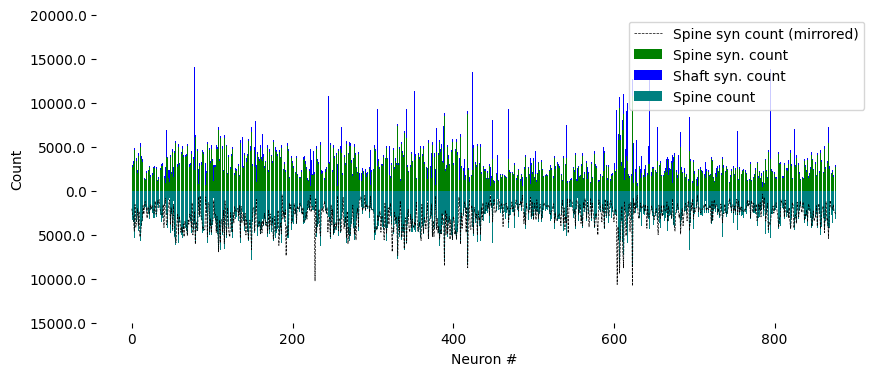

In [19]:
plt.figure(figsize=(10, 4))
plt.bar(range(len(nrn_props)), nrn_props["syn_count_on_spines"],
        color="green", label="Spine syn. count")
plt.bar(range(len(nrn_props)), 
        nrn_props["syn_count_on_shafts"],
        bottom=nrn_props["syn_count_on_spines"],
        color="blue", label="Shaft syn. count")
plt.bar(range(len(nrn_props)), -nrn_props["spine_count"],
        color="teal", label="Spine count")
plt.plot(range(len(nrn_props)), -nrn_props["syn_count_on_spines"],
         ls="--", color="black", lw=0.5, label="Spine syn count (mirrored)")

ax = plt.gca()
plt.legend()
ax.set_frame_on(False)
ax.set_xlabel("Neuron #")
ax.set_ylabel("Count")
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(numpy.abs(ax.get_yticks()))

We also notice a number of outlying neurons with a very large number of synapses onto shafts (blue).
We look up which type they are by calculating the mean shaft synapse count per neuron type.

Unsurprisingly, the types with by far the highest shaft count are the non-spiny types, especially PTC (proximally targeting neurons, i.e., Basket Cells)

In [20]:
nrn_props.groupby("mtype")["syn_count_on_shafts"].mean()

/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/ipykernel_91815/1748931632.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nrn_props.groupby("mtype")["syn_count_on_shafts"].mean()


mtype
L3a           283.475410
L3b           231.913043
L4b           146.829114
L4a           197.931373
DTC          2665.406250
L5a           526.916667
PTC          5520.882353
L2c           288.480000
ITC          1735.090909
L2a           322.684211
L2b           201.687500
STC          1332.875000
L4c           240.714286
L5b           467.833333
L5ET         1241.111111
L5NP          333.000000
L6short-a     297.333333
L6tall-a      322.153846
L6short-b     122.000000
L6tall-b      196.666667
L6tall-c      298.750000
Name: syn_count_on_shafts, dtype: float64

Which presynaptic types place synapses on spines vs. shafts?

100%|██████████| 877/877 [00:07<00:00, 109.86it/s]


Text(0, 0.5, 'Fraction syns. on spines')

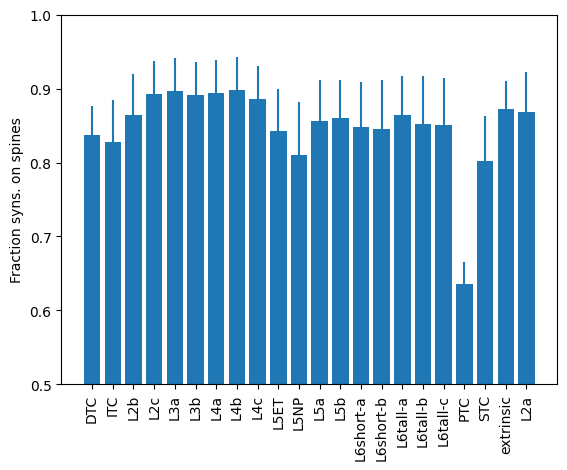

In [21]:
def lookup_presynaptic_property2(df_in, property_names):
    edge_pop = df_in.index[0][0]
    if edge_pop == "em_extrinsic__microns_intrinsic__chemical":
        return pandas.DataFrame([["extrinsic"] * len(property_names)] * df_in.shape[0],
                             index=df_in["@source_node"],
                             columns=property_names)
    source_name = circ.edges[edge_pop].source.name
    lo = circ.nodes[source_name].get(df_in["@source_node"], properties=property_names)
    return lo.reindex(df_in["@source_node"])

per_pre_mtype_fractions = []
for nrn_id in tqdm.tqdm(nrn_props.index):
    syns = synapses_from_all_edge_populations(nrn_id)
    pre_mtypes = syns.groupby("edge_population").apply(lookup_presynaptic_property2, ["mtype"]).set_index(syns.index)
    mtypes_and_is_on_spine = pandas.concat([pre_mtypes, syns["spine_id"] > -1], axis=1)
    res_for_neuron = mtypes_and_is_on_spine.value_counts().unstack("mtype", fill_value=0)
    res_for_neuron = res_for_neuron.loc[True] / res_for_neuron.sum()
    per_pre_mtype_fractions.append(res_for_neuron)

per_pre_mtype_fractions = pandas.concat(per_pre_mtype_fractions, axis=1)
mn_vals = per_pre_mtype_fractions.mean(axis=1)
smpl_counts = (~numpy.isnan(mn_vals)).sum(axis=0)
sem_vals = per_pre_mtype_fractions.std(axis=1) / numpy.sqrt(smpl_counts)

plt.bar(range(len(mn_vals)), mn_vals)
plt.errorbar(range(len(mn_vals)), mn_vals, yerr=sem_vals, ls="None")
plt.gca().set_xticks(range(len(mn_vals)))
plt.gca().set_xticklabels(mn_vals.index, rotation="vertical")
plt.gca().set_ylim([0.5, 1.0])
plt.gca().set_ylabel("Fraction syns. on spines")

## Plot exemplar morphology and its synapses

We plot an examplar morphology and all its afferent synapses. 

Shaft synapses in blue, spine synapses in green.

We see the shaft synapses are more prevalent around the soma than elsewhere. This is easier to see if you uncomment the last code line to zoom into the soma a bit more.

/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/morph_tool/transform.py:41: RuntimeWarning: divide by zero encountered in dot
  return np.dot(np.column_stack((p, np.ones(len(p)))), A)[:, :3]
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/morph_tool/transform.py:41: RuntimeWarning: overflow encountered in dot
  return np.dot(np.column_stack((p, np.ones(len(p)))), A)[:, :3]
/Users/mwr/venvs/entitysdk_notebook/lib/python3.13/site-packages/morph_tool/transform.py:41: RuntimeWarning: invalid value encountered in dot
  return np.dot(np.column_stack((p, np.ones(len(p)))), A)[:, :3]


(420.0, 800.0)

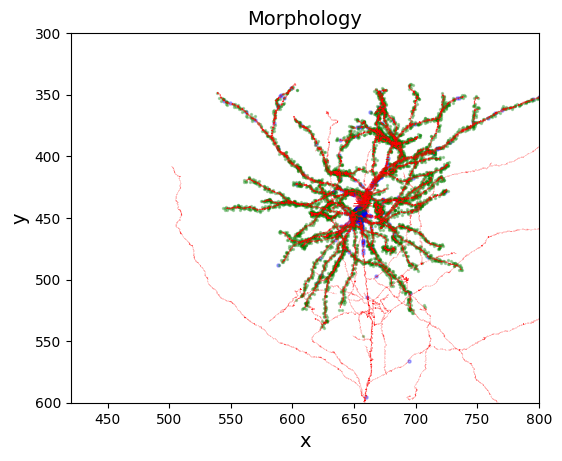

In [ ]:
import neurom
import neurom.view

morph = neurom.load_morphology(node_pop.morph.get(nrn_id, extension="h5", transform=True))
syns = synapses_from_all_edge_populations(nrn_id)

neurom.view.plot_morph(morph, diameter_scale=3)
ax = plt.gca()
ax.scatter(syns.afferent_synapse_x[syns.spine_id == -1],
           syns.afferent_synapse_y[syns.spine_id == -1], s=5, alpha=0.3, color="blue")
ax.scatter(syns.afferent_synapse_x[syns.spine_id != -1],
           syns.afferent_synapse_y[syns.spine_id != -1], s=2, alpha=0.3, color="green")

ax.set_ylim([600, 300]); ax.set_xlim([420, 800])
# To zoom into the soma
# ax.set_ylim([475, 425]); ax.set_xlim([625, 675])

## Plot exemplar morphology, synapses -- and SPINES

We plot the same exemplar again, this time also with the extracted spines.

As mentioned above, at this point we only offer the very reduced representation of spines as lines. But soon more involved representations will be available. 

Still, we can see nicely how each spine projects outwards from its dendrite to "catch" its associated synapse.

(625.0, 675.0)

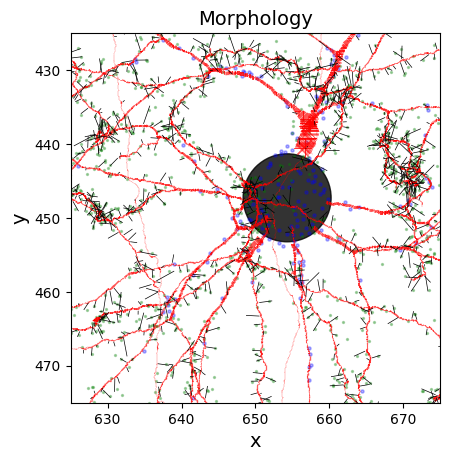

In [ ]:
import neurom
import neurom.view

morph = neurom.load_morphology(node_pop.morph.get(nrn_id, extension="h5", transform=True))
syns = synapses_from_all_edge_populations(nrn_id)
spines = read_spine_info(node_pop, nrn_id)

neurom.view.plot_morph(morph, diameter_scale=3)
ax = plt.gca()
ax.scatter(syns.afferent_synapse_x[syns.spine_id == -1],
           syns.afferent_synapse_y[syns.spine_id == -1], s=5, alpha=0.3, color="blue")
ax.scatter(syns.afferent_synapse_x[syns.spine_id != -1],
           syns.afferent_synapse_y[syns.spine_id != -1], s=2, alpha=0.3, color="green")

for _, spine in spines.iterrows():
    spine_root = numpy.array(spine.surface_sample_position)
    spine_dir = numpy.array(spine.orientation_vector)
    spine_dir = spine.synaptic_radius * spine_dir / numpy.linalg.norm(spine_dir)
    ax.plot([spine_root[0], spine_root[0] + spine_dir[0]],
            [spine_root[1], spine_root[1] + spine_dir[1]],
            color="black", lw=0.5)

ax.set_ylim([600, 300]); ax.set_xlim([400, 800])
# To zoom into the soma
ax.set_ylim([475, 425]); ax.set_xlim([625, 675])

## Calculating synapse path distances to the soma.

The synapse properties "afferent_section_id", "afferent_segment_id", "afferent_segment_offset" map each synapse to a location on the morphology skeleton. 

Hence, that information can be used to rapidly calculate path distances between pairs of synapses. Or the path distance of a synapse to the soma. This information is useful for applications in the field of dendritic clustering of synapses.

**NOTE**: What is calculated is the path distance from the root of the spine of a synapse, not including the length of the spine itself.

Here, we calculate for all synapses their path distance to the soma (represented by section and segment id 0) and create a histogram.

Text(0, 0.5, 'Synapse count')

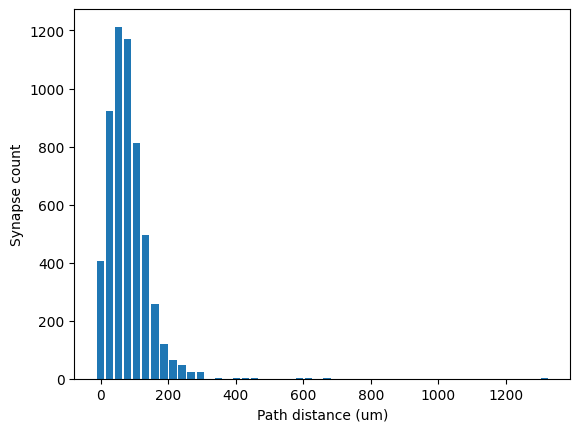

In [31]:
from conntility.subcellular import MorphologyPathDistanceCalculator

calc = MorphologyPathDistanceCalculator(morph.to_morphio())
relevant_cols = ["afferent_section_id", "afferent_segment_id", "afferent_segment_offset"]
soma = pandas.DataFrame({
    "afferent_section_id": [0], "afferent_segment_id": [0], "afferent_segment_offset": [0]
})

pds = calc.path_distances(soma, syns[relevant_cols])

H = numpy.histogram(pds, bins=50)
plt.bar(H[1][:-1], H[0], width=0.8*numpy.mean(numpy.diff(H[1])))
plt.gca().set_xlabel("Path distance (um)")
plt.gca().set_ylabel("Synapse count")